<a href="https://colab.research.google.com/github/shravankumargulvadi/Assignment-11/blob/master/Assignment_11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Assignment-11

## 1. Data Set: CIFAR 10
## 2. Network: CNN
## 3. Image augmentation used: Cutout
## 4. Optimizer: SGD with Momentum
## 5. Used 'LR Finder' to ascertain an optimal Starting point for the learning rate.
## 6. Employed GradCam on first 25 missclassified images for visualization.








In [0]:
import keras
from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2017) 
from keras import regularizers
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D,AveragePooling2D
from keras.layers import Activation, Flatten, Dense, Dropout
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
from keras.callbacks import Callback

In [0]:
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_rows, img_cols,img_channels =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

In [159]:
print (num_classes)
print (num_train)
print (train_features.shape)

10
50000
(50000, 32, 32, 3)


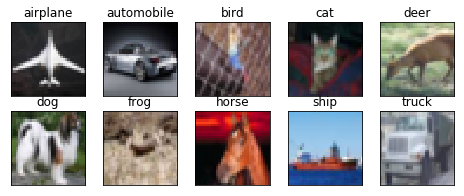

In [160]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

In [0]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [0]:
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

In [0]:
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255
# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

In [164]:
train_labels

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]], dtype=float32)

In [165]:
# load dataset
(trainX, trainy), (testX, testy) = cifar10.load_data()


print('Statistics train=%.3f (%.3f), test=%.3f (%.3f)' % (trainX.mean(), trainX.std(), testX.mean(), testX.std()))

# create generator that centers pixel values
datagen = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True)

# calculate the mean on the training dataset
datagen.fit(trainX)
#print('Data Generator mean=%.3f, std=%.3f' % (datagen.mean, datagen.std))

# demonstrate effect on a single batch of samples
iterator = datagen.flow(trainX, trainy, batch_size=128)

# get a batch
batchX, batchy = iterator.next()

# pixel stats in the batch
print(batchX.shape, batchX.mean(), batchX.std())

# demonstrate effect on entire training dataset
iterator = datagen.flow(trainX, trainy, batch_size=len(trainX), shuffle=False)

# get a batch
batchX, batchy = iterator.next()

# pixel stats in the batch
print(batchX.shape, batchX.mean(), batchX.std())

Statistics train=120.708 (64.150), test=121.529 (64.061)
(128, 32, 32, 3) 0.01989002 1.0052702
(50000, 32, 32, 3) -1.6605131e-06 1.0000001


In [0]:
iterator1 = datagen.flow(testX, testy, batch_size=len(testX), shuffle=False)
batch_testX, batch_testy = iterator1.next()

X_train = batchX
X_test = batch_testX

y_train=batchy
y_test=batch_testy
                        

In [0]:
# Convert 1-dimensional class arrays to 10-dimensional class matrices
Y_train = np_utils.to_categorical(y_train, 10)
Y_test = np_utils.to_categorical(y_test, 10)

In [0]:
def cutout(img):
        """
        Args:
            img (Tensor): Tensor image of size (C, H, W).
        Returns:
            Tensor: Image with n_holes of dimension length x length cut out of it.
        """
        n_holes=1
        length=8
        img= np.array(img)
        h = img.shape[0]
        w = img.shape[1]
        

        mask = np.ones((h, w, 3), np.float32)

        for n in range(n_holes):
            y = np.random.randint(h)
            x = np.random.randint(w)

            y1 = int(np.clip(y - length // 2, 0, h))
            y2 = int(np.clip(y + length // 2, 0, h))
            x1 = int(np.clip(x - length // 2, 0, w))
            x2 = int(np.clip(x + length // 2, 0, w))

            mask[y1: y2, x1: x2] = 0.
            #print(mask, img.shape, y, x )

      
       
        img = img * mask
       
   
      

        return img

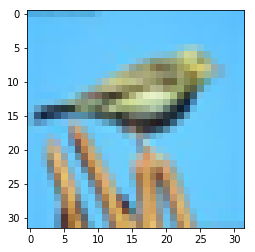

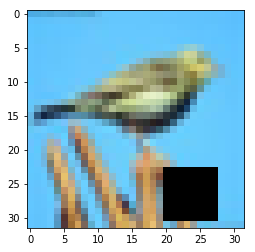

In [169]:
new_image= cutout(test_features[67])
plt.imshow(test_features[67])
plt.show()
plt.imshow(new_image)
plt.show()

#cv2_imshow(new_image)



In [170]:
# Define the model
model1 = Sequential()
model1.add(Convolution2D(32, 3, 3, border_mode='same',kernel_regularizer=regularizers.l2(0.0001), input_shape=(32, 32, 3)))
model1.add(Activation('relu'))
model1.add(BatchNormalization())

model1.add(Convolution2D(64, 3, 3,kernel_regularizer=regularizers.l2(0.0001),border_mode='same'))
model1.add(Activation('relu'))
model1.add(BatchNormalization())

model1.add(MaxPooling2D(pool_size=(2, 2)))
model1.add(Dropout(0.2))

model1.add(Convolution2D(32, 1, 1))


model1.add(Convolution2D(64, 3, 3,kernel_regularizer=regularizers.l2(0.0001),border_mode='same'))
model1.add(Activation('relu'))
model1.add(BatchNormalization())

model1.add(Convolution2D(128, 3, 3,kernel_regularizer=regularizers.l2(0.0001),border_mode='same'))
model1.add(Activation('relu'))
model1.add(BatchNormalization())

model1.add(MaxPooling2D(pool_size=(2, 2)))
model1.add(Dropout(0.3))

model1.add(Convolution2D(32, 1, 1))


model1.add(Convolution2D(128, 3, 3,kernel_regularizer=regularizers.l2(0.0001), border_mode='same'))
model1.add(Activation('relu'))
model1.add(BatchNormalization())

model1.add(Convolution2D(256, 3, 3,kernel_regularizer=regularizers.l2(0.0001), border_mode='same'))
model1.add(Activation('relu'))
model1.add(BatchNormalization())

model1.add(MaxPooling2D(pool_size=(2, 2)))
model1.add(Dropout(0.5))

model1.add(Convolution2D(10, 1, 1))

model1.add(AveragePooling2D(pool_size = (4,4)))
model1.add(Flatten())


model1.add(Activation('softmax'))

# Compile the model
model1.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), kernel_regularizer=<keras.reg..., input_shape=(32, 32, 3..., padding="same")`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), kernel_regularizer=<keras.reg..., padding="same")`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (1, 1))`
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), kernel_regularizer=<keras.reg..., padding="same")`
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), kernel_regularizer=<keras.reg..., padding="same"

In [171]:
model1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_52 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
activation_43 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_37 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_53 (Conv2D)           (None, 32, 32, 64)        18496     
_________________________________________________________________
activation_44 (Activation)   (None, 32, 32, 64)        0         
_________________________________________________________________
batch_normalization_38 (Batc (None, 32, 32, 64)        256       
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 16, 16, 64)        0         
__________

## LR Finder Implementation

In [0]:
class LR_Finder(Callback):
    
    def __init__(self, start_lr=1e-5, end_lr=10, step_size=None, beta=.98):
        super().__init__()
        
        self.start_lr = start_lr
        self.end_lr = end_lr
        self.step_size = step_size
        self.beta = beta
        self.lr_mult = (end_lr/start_lr)**(1/step_size)
        
    def on_train_begin(self, logs=None):
        self.best_loss = 1e9
        self.avg_loss = 0
        self.losses, self.smoothed_losses, self.lrs, self.iterations = [], [], [], []
        self.iteration = 0
        logs = logs or {}
        K.set_value(self.model.optimizer.lr, self.start_lr)
        
    def on_batch_end(self, epoch, logs=None):
        logs = logs or {}
        loss = logs.get('loss')
        self.iteration += 1
        
        self.avg_loss = self.beta * self.avg_loss + (1 - self.beta) * loss
        smoothed_loss = self.avg_loss / (1 - self.beta**self.iteration)
        
        # Check if the loss is not exploding
        if self.iteration>1 and smoothed_loss > self.best_loss * 4:
            self.model.stop_training = True
            return

        if smoothed_loss < self.best_loss or self.iteration==1:
            self.best_loss = smoothed_loss
        
        lr = self.start_lr * (self.lr_mult**self.iteration)
        
        self.losses.append(loss)
        self.smoothed_losses.append(smoothed_loss)
        self.lrs.append(lr)
        self.iterations.append(self.iteration)
        
        
        K.set_value(self.model.optimizer.lr, lr)  
        
    def plot_lr(self):
        plt.xlabel('Iterations')
        plt.ylabel('Learning rate')
        plt.plot(self.iterations, self.lrs)
        
    def plot(self, n_skip=10):
        plt.ylabel('Loss')
        plt.xlabel('Learning rate (log scale)')
        plt.plot(self.lrs[n_skip:-5], self.losses[n_skip:-5])
        plt.xscale('log')
        
    def plot_smoothed_loss(self, n_skip=10):
        plt.ylabel('Smoothed Losses')
        plt.xlabel('Learning rate (log scale)')
        plt.plot(self.lrs[n_skip:-5], self.smoothed_losses[n_skip:-5])
        plt.xscale('log')
        
    def plot_loss(self):
        plt.ylabel('Losses')
        plt.xlabel('Iterations')
        plt.plot(self.iterations[10:], self.losses[10:])

In [173]:

bs=128

lr_finder = LR_Finder(start_lr=1e-5, end_lr=10, step_size=np.ceil(X_train.shape[0]/bs))
model1.fit(X_train, Y_train, callbacks=[lr_finder])

Epoch 1/1
12864/50000 [======>.......................] - ETA: 17s - loss: 4.0592 - acc: 0.1606

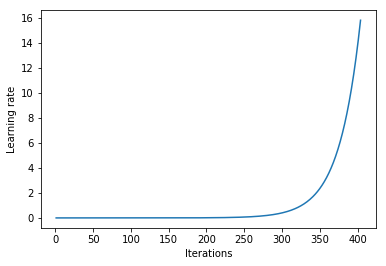

In [174]:
lr_finder.plot_lr()

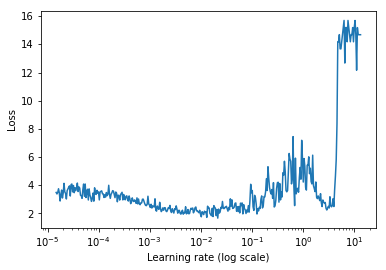

In [175]:
lr_finder.plot()

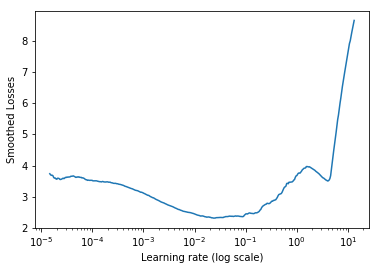

In [176]:
lr_finder.plot_smoothed_loss()

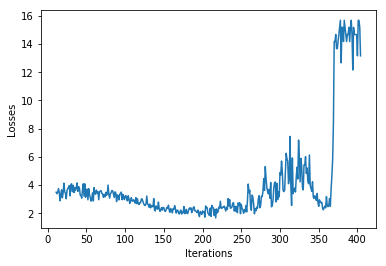

In [177]:
lr_finder.plot_loss()

## As seen in the graph the optimal region for LR initialization is between 0.01 and 0.1, hence initializing at 0.01.

In [178]:
# Define the model
model1 = Sequential()
model1.add(Convolution2D(32, 3, 3, border_mode='same',kernel_regularizer=regularizers.l2(0.0001), input_shape=(32, 32, 3)))
model1.add(Activation('relu'))
model1.add(BatchNormalization())

model1.add(Convolution2D(64, 3, 3,kernel_regularizer=regularizers.l2(0.0001),border_mode='same'))
model1.add(Activation('relu'))
model1.add(BatchNormalization())

model1.add(MaxPooling2D(pool_size=(2, 2)))
model1.add(Dropout(0.2))

model1.add(Convolution2D(32, 1, 1))


model1.add(Convolution2D(64, 3, 3,kernel_regularizer=regularizers.l2(0.0001),border_mode='same'))
model1.add(Activation('relu'))
model1.add(BatchNormalization())

model1.add(Convolution2D(128, 3, 3,kernel_regularizer=regularizers.l2(0.0001),border_mode='same'))
model1.add(Activation('relu'))
model1.add(BatchNormalization())

model1.add(MaxPooling2D(pool_size=(2, 2)))
model1.add(Dropout(0.3))

model1.add(Convolution2D(32, 1, 1))


model1.add(Convolution2D(128, 3, 3,kernel_regularizer=regularizers.l2(0.0001), border_mode='same'))
model1.add(Activation('relu'))
model1.add(BatchNormalization())

model1.add(Convolution2D(256, 3, 3,kernel_regularizer=regularizers.l2(0.0001), border_mode='same', name='logit'))
model1.add(Activation('relu'))
model1.add(BatchNormalization())

model1.add(MaxPooling2D(pool_size=(2, 2)))
model1.add(Dropout(0.5))

model1.add(Convolution2D(10, 1, 1))

model1.add(AveragePooling2D(pool_size = (4,4)))
model1.add(Flatten())


model1.add(Activation('softmax'))

# Compile the model
keras.optimizers.SGD(lr=0.01, momentum=0.9, decay=0.0, nesterov=False)
model1.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), kernel_regularizer=<keras.reg..., input_shape=(32, 32, 3..., padding="same")`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), kernel_regularizer=<keras.reg..., padding="same")`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (1, 1))`
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), kernel_regularizer=<keras.reg..., padding="same")`
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), kernel_regularizer=<keras.reg..., padding="same"

In [0]:
filepath="weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., verbose=0, callbacks=[<keras.ca..., steps_per_epoch=390, epochs=100)`
  if __name__ == '__main__':



Epoch 00001: val_acc improved from -inf to 0.52040, saving model to weights.best.hdf5

Epoch 00002: val_acc improved from 0.52040 to 0.58490, saving model to weights.best.hdf5

Epoch 00003: val_acc improved from 0.58490 to 0.60410, saving model to weights.best.hdf5

Epoch 00004: val_acc improved from 0.60410 to 0.64520, saving model to weights.best.hdf5

Epoch 00005: val_acc improved from 0.64520 to 0.65410, saving model to weights.best.hdf5

Epoch 00006: val_acc improved from 0.65410 to 0.67200, saving model to weights.best.hdf5

Epoch 00007: val_acc improved from 0.67200 to 0.68120, saving model to weights.best.hdf5

Epoch 00008: val_acc improved from 0.68120 to 0.68490, saving model to weights.best.hdf5

Epoch 00009: val_acc improved from 0.68490 to 0.69330, saving model to weights.best.hdf5

Epoch 00010: val_acc improved from 0.69330 to 0.70050, saving model to weights.best.hdf5

Epoch 00011: val_acc did not improve from 0.70050

Epoch 00012: val_acc improved from 0.70050 to 0.702

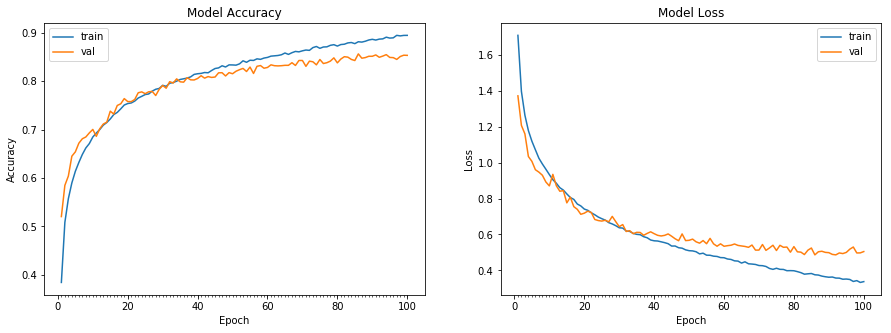

Accuracy on test data is: 85.36


In [180]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(zoom_range=0.0, 
                             horizontal_flip=False, preprocessing_function=cutout)
# train the model
start = time.time()
# Train the model
model_info = model1.fit_generator(datagen.flow(X_train, Y_train, batch_size = 128), 
                                  samples_per_epoch = train_features.shape[0], nb_epoch = 100, validation_data = (X_test, Y_test), verbose=0, callbacks=callbacks_list)
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(X_test, Y_test, model1))

In [181]:
miscls=[]
missed_targets=[]
actual_targets=[]
for i in range(10000):
 predicted = model1.predict(X_test[i].reshape(1, 32, 32, 3))
 Y_test[i]=Y_test[i].reshape(1, 10)
 Y=np.argmax(Y_test[i])
 predicted=np.argmax(predicted, axis=1)
 if predicted!=Y:
  miscls.append(i)
  predicted=int(predicted)
  missed_targets.append(predicted)
  actual_targets.append(Y)
print(miscls)
len(miscls)

[20, 21, 25, 35, 52, 57, 58, 61, 76, 78, 85, 91, 103, 106, 128, 139, 143, 145, 147, 162, 165, 178, 188, 189, 195, 210, 211, 215, 221, 224, 228, 245, 247, 251, 258, 263, 264, 287, 303, 309, 313, 314, 323, 332, 352, 355, 356, 376, 378, 383, 384, 388, 401, 411, 422, 426, 430, 433, 434, 441, 450, 456, 468, 470, 473, 485, 488, 518, 531, 537, 551, 565, 577, 598, 641, 646, 655, 665, 669, 671, 676, 680, 682, 683, 685, 689, 715, 720, 725, 727, 734, 739, 740, 749, 751, 770, 771, 773, 790, 792, 798, 799, 802, 811, 819, 833, 836, 845, 853, 862, 866, 882, 883, 888, 889, 893, 898, 900, 916, 923, 924, 925, 943, 948, 953, 956, 957, 972, 974, 982, 1001, 1002, 1019, 1024, 1040, 1042, 1043, 1049, 1050, 1053, 1056, 1072, 1074, 1088, 1095, 1100, 1118, 1124, 1126, 1129, 1130, 1131, 1137, 1138, 1147, 1150, 1163, 1172, 1177, 1181, 1193, 1199, 1219, 1222, 1224, 1227, 1230, 1241, 1247, 1248, 1265, 1266, 1272, 1277, 1285, 1297, 1303, 1309, 1325, 1334, 1339, 1346, 1353, 1355, 1373, 1389, 1391, 1393, 1394, 1399, 1

1464

In [182]:
to_print=miscls[0:25]
missed_targets=missed_targets[0:25]
print(missed_targets)
actual_targets=actual_targets[0:25]
print(actual_targets)



[5, 2, 5, 8, 7, 3, 5, 5, 0, 5, 7, 6, 6, 6, 6, 8, 7, 5, 6, 3, 2, 3, 2, 8, 3]
[7, 0, 2, 2, 0, 7, 4, 3, 9, 3, 5, 3, 3, 3, 5, 9, 3, 7, 2, 6, 4, 5, 4, 0, 2]


W0721 14:18:27.081596 140278958495616 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0721 14:18:27.083372 140278958495616 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0721 14:18:27.085513 140278958495616 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0721 14:18:27.088115 140278958495616 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0721 14:18:27.090445 140278958495616 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0721 14:18:27.092384 140278958495616 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0721 14:18:27.094558 140278

IndexError: ignored

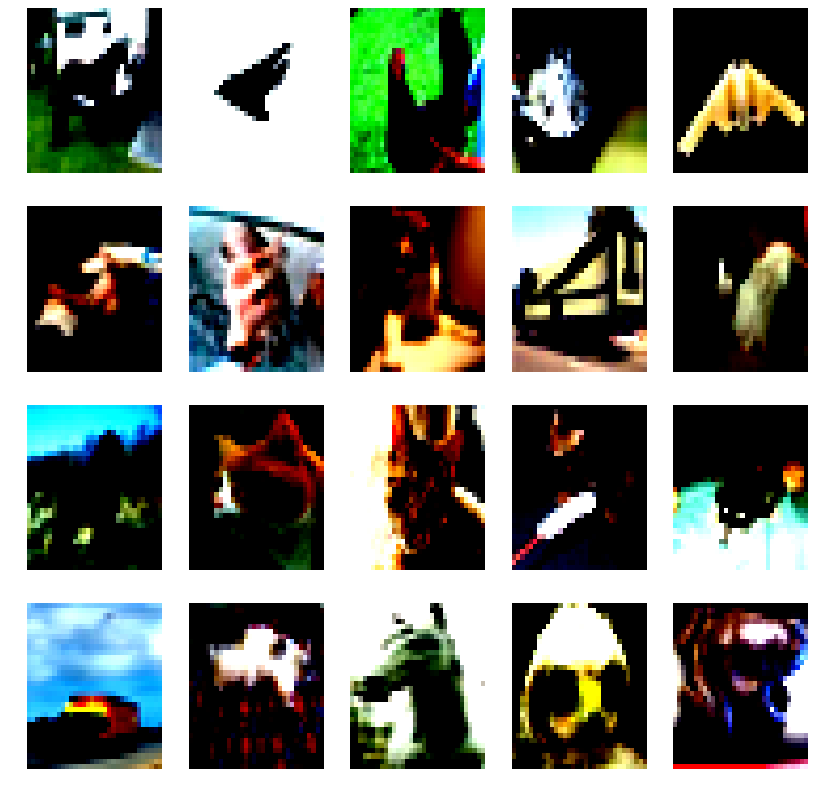

In [183]:

fig, axes= plt.subplots(nrows=4, ncols=5, figsize=(14, 14))
images=[img.reshape(32, 32,3) for index, img in enumerate(X_test) if index in to_print]
for idx, image in enumerate(images):
  row= idx // 5
  col= idx % 5
  axes[row, col].axis("off")
  axes[row, col].imshow(image, aspect="auto")
plt.subplots_adjust(wspace=.05, hspace=.05)
plt.show()

 

In [0]:
imgt=test_features[1]
#X_test = X_test.astype('float32')/255
#imgt= X_test[1]
im = imgt.reshape(1, 32, 32, 3)
#plt.imshow(im)
preds = model1.predict(im)
class_idx = np.argmax(preds[0])
class_output = model1.output[:, class_idx]
last_conv_layer = model1.get_layer('logit')


In [0]:
grads = K.gradients(class_output, last_conv_layer.output)[0]
pooled_grads = K.mean(grads, axis=(0, 1, 2))
iterate = K.function([model1.input], [pooled_grads, last_conv_layer.output[0]])
pooled_grads_value, conv_layer_output_value = iterate([im])
for i in range(256):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

## GradCam Visualization on first 25 missclassified images with predicted and actual class labels:

W0721 14:28:30.192246 140278958495616 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Test Data index:
20
expected target class
horse
predicted class
dog




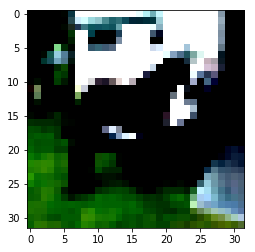

W0721 14:28:30.317407 140278958495616 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


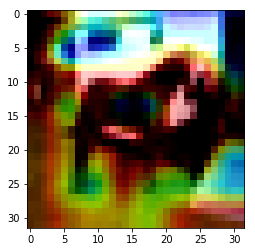

W0721 14:28:30.445583 140278958495616 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Test Data index:
21
expected target class
airplane
predicted class
bird




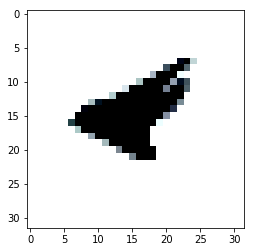

W0721 14:28:30.568378 140278958495616 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


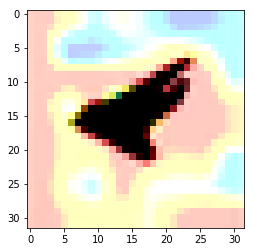

W0721 14:28:30.692507 140278958495616 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Test Data index:
25
expected target class
bird
predicted class
dog




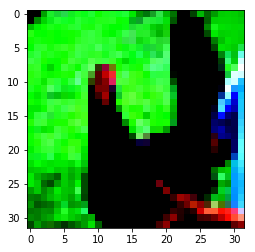

W0721 14:28:30.816394 140278958495616 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


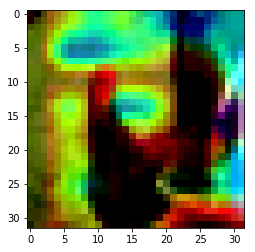

W0721 14:28:30.940954 140278958495616 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Test Data index:
35
expected target class
bird
predicted class
ship




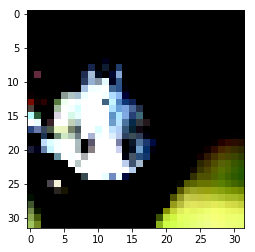

W0721 14:28:31.084106 140278958495616 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


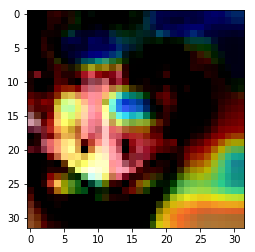

W0721 14:28:31.224969 140278958495616 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Test Data index:
52
expected target class
airplane
predicted class
horse




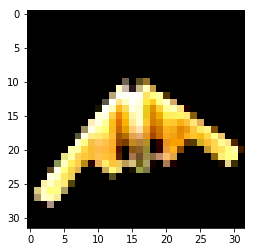

W0721 14:28:31.356215 140278958495616 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


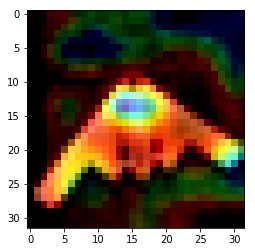

W0721 14:28:31.485713 140278958495616 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Test Data index:
57
expected target class
horse
predicted class
cat




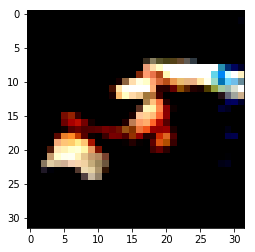

W0721 14:28:31.613943 140278958495616 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


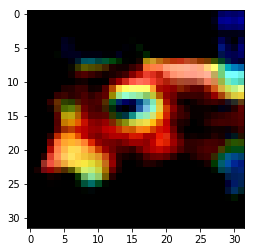

W0721 14:28:31.745182 140278958495616 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Test Data index:
58
expected target class
deer
predicted class
dog




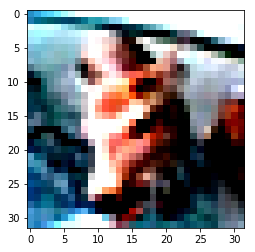

W0721 14:28:31.879379 140278958495616 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


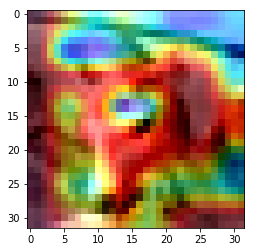

W0721 14:28:32.018660 140278958495616 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Test Data index:
61
expected target class
cat
predicted class
dog




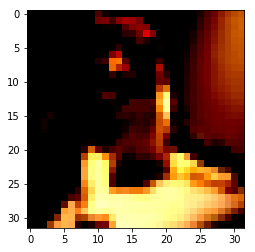

W0721 14:28:32.161497 140278958495616 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


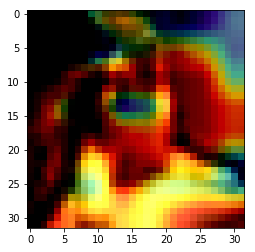

W0721 14:28:32.302855 140278958495616 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Test Data index:
76
expected target class
truck
predicted class
airplane




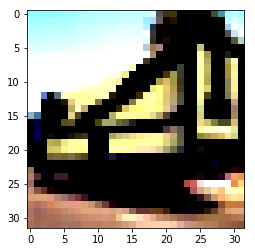

W0721 14:28:32.441950 140278958495616 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


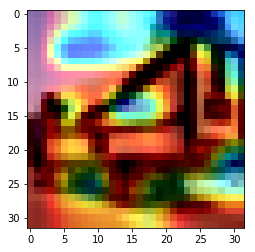

W0721 14:28:32.608371 140278958495616 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Test Data index:
78
expected target class
cat
predicted class
dog




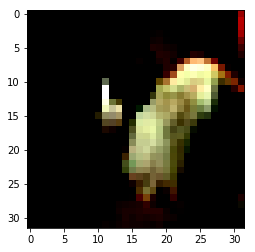

W0721 14:28:32.767278 140278958495616 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


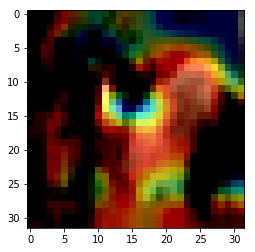

W0721 14:28:32.925575 140278958495616 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Test Data index:
85
expected target class
dog
predicted class
horse




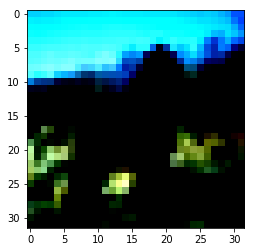

W0721 14:28:33.095935 140278958495616 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


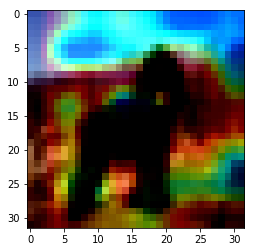

W0721 14:28:33.254505 140278958495616 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Test Data index:
91
expected target class
cat
predicted class
frog




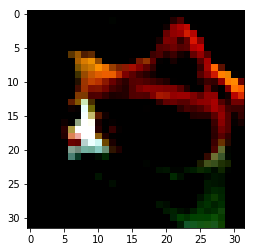

W0721 14:28:33.411082 140278958495616 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


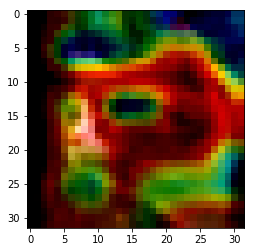

W0721 14:28:33.572844 140278958495616 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Test Data index:
103
expected target class
cat
predicted class
frog




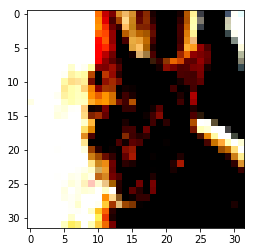

W0721 14:28:33.730805 140278958495616 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


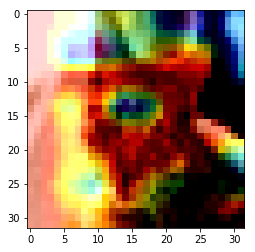

W0721 14:28:33.918347 140278958495616 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Test Data index:
106
expected target class
cat
predicted class
frog




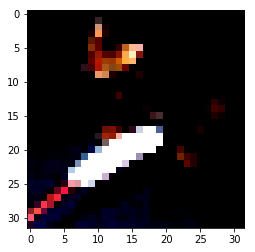

W0721 14:28:34.087690 140278958495616 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


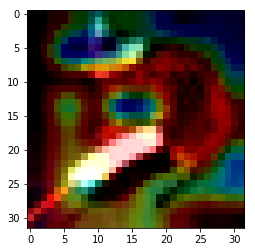

W0721 14:28:34.249747 140278958495616 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Test Data index:
128
expected target class
dog
predicted class
frog




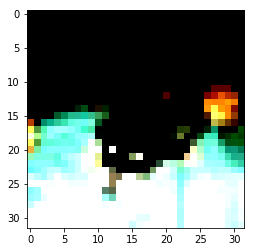

W0721 14:28:34.408201 140278958495616 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


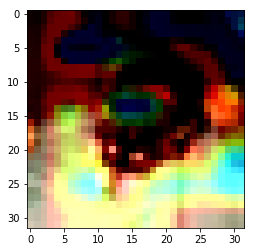

W0721 14:28:34.563904 140278958495616 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Test Data index:
139
expected target class
truck
predicted class
ship




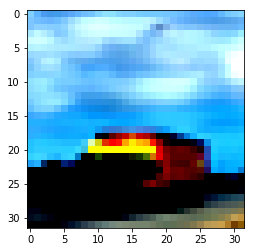

W0721 14:28:34.719431 140278958495616 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


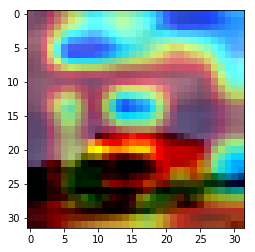

W0721 14:28:34.875260 140278958495616 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Test Data index:
143
expected target class
cat
predicted class
horse




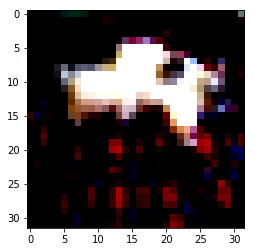

W0721 14:28:35.041731 140278958495616 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


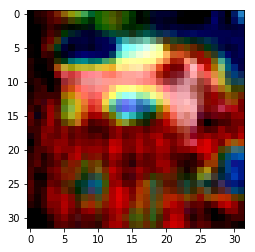

W0721 14:28:35.216027 140278958495616 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Test Data index:
145
expected target class
horse
predicted class
dog




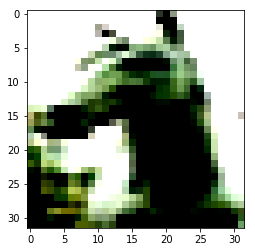

W0721 14:28:35.377094 140278958495616 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


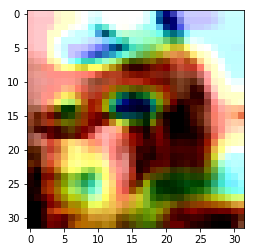

W0721 14:28:35.537672 140278958495616 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Test Data index:
147
expected target class
bird
predicted class
frog




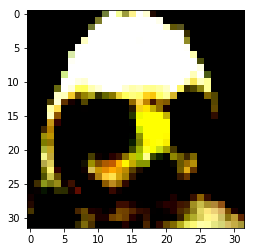

W0721 14:28:35.695823 140278958495616 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


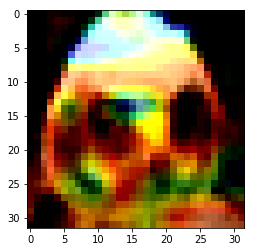

W0721 14:28:35.862791 140278958495616 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Test Data index:
162
expected target class
frog
predicted class
cat




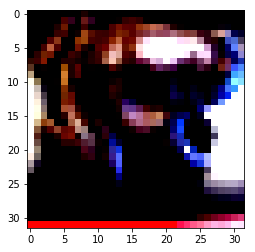

W0721 14:28:36.022621 140278958495616 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


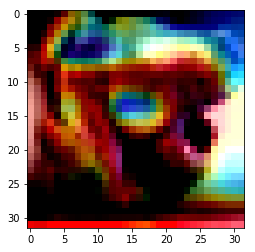

W0721 14:28:36.206833 140278958495616 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Test Data index:
165
expected target class
deer
predicted class
bird




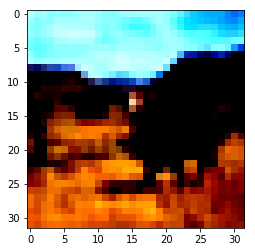

W0721 14:28:36.367178 140278958495616 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


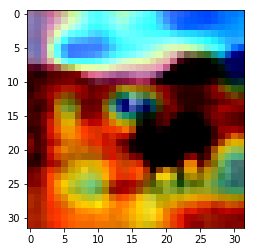

W0721 14:28:36.525730 140278958495616 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Test Data index:
178
expected target class
dog
predicted class
cat




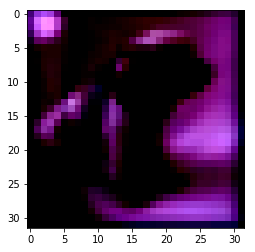

W0721 14:28:36.683742 140278958495616 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


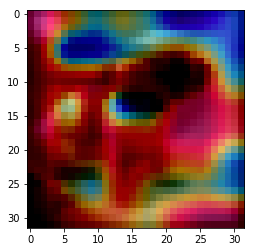

W0721 14:28:36.848841 140278958495616 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Test Data index:
188
expected target class
deer
predicted class
bird




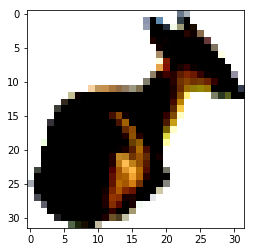

W0721 14:28:37.009938 140278958495616 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


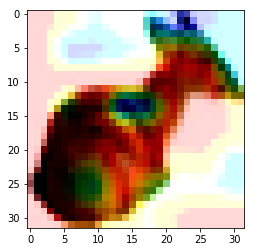

W0721 14:28:37.182536 140278958495616 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Test Data index:
189
expected target class
airplane
predicted class
ship




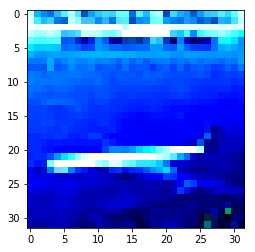

W0721 14:28:37.347711 140278958495616 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


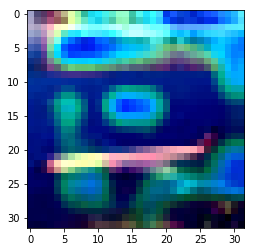

W0721 14:28:37.508960 140278958495616 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Test Data index:
195
expected target class
bird
predicted class
cat




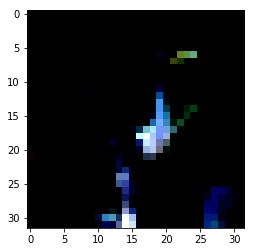

W0721 14:28:37.668260 140278958495616 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


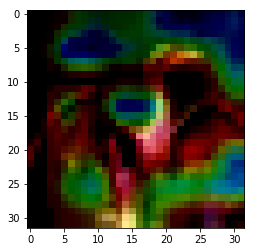

In [190]:
import cv2
for idx, image in enumerate(images):
  
#for i in range (20):
    heatmap = np.mean(conv_layer_output_value, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)
    
    type(heatmap)
    
    img = images[idx]
    
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    
    heatmap = heatmap.astype('float32')/255
    superimposed_img = cv2.addWeighted(img, 0.4, heatmap, 0.6, 0)
    print('Test Data index:')
    print(to_print[idx])
    print('expected target class')
    print(class_names[actual_targets[idx]])
    print('predicted class')
    print(class_names [missed_targets[idx]])
    print('\n')
    plt.imshow(img)
    plt.show()
    plt.imshow(superimposed_img)
    plt.show()
    
 